In [1]:
# local import for testing
import sys, os
sys.path.insert(1, '../src/SupplyNetPy/Components/')
import core as scm
import utilities as scm
import simpy


def print_performance_metrics(supplychainnet):
    print("Performance Metrics:")
    print("Total Available Inventory:", supplychainnet["total_available_inv"])
    print("Average Available Inventory:", supplychainnet["avg_available_inv"])
    print("Total Inventory Carry Cost:", supplychainnet["total_inv_carry_cost"])
    print("Total Inventory Spend:", supplychainnet["total_inv_spend"])
    print("Total Transport Cost:", supplychainnet["total_transport_cost"])
    print("Total Revenue:", supplychainnet["total_revenue"])
    print("Total Cost:", supplychainnet["total_cost"])
    print("Total Profit:", supplychainnet["total_profit"])
    print("Total Demand Placed by Customers:", supplychainnet["total_demand_by_customers"])
    print("Total Fulfillment Received by Customers:", supplychainnet["total_fulfillment_received_by_customers"])
    print("Total Demand Placed by Site:", supplychainnet["total_demand_by_site"])
    print("Total Fulfillment Received by Site:", supplychainnet["total_fulfillment_received_by_site"])
    print("Total Demand Placed:", supplychainnet["total_demand"])
    print("Total Fulfillment Received:", supplychainnet["total_fulfillment_received"])
    print("Average Cost per Order:", supplychainnet["avg_cost_per_order"])
    print("Average Cost per Item:", supplychainnet["avg_cost_per_item"])

INFO Distribution Center 1 - 0.0000:D1: Inventory levels:1000
INFO Distribution Center 2 - 0.0000:D2: Inventory levels:1500
INFO Demand 1 - 0.0000:demand_D1:Customer1:Order quantity:20, available.
INFO Distribution Center 1 - 0.0000:D1: Inventory levels:940
INFO Demand 2 - 0.0000:demand_D2:Customer1:Order quantity:40, available.
INFO Demand 3 - 0.0000:demand_D3:Customer1:Order quantity:60, available.
INFO Distribution Center 2 - 0.0000:D2: Inventory levels:1360
INFO Demand 4 - 0.0000:demand_D4:Customer1:Order quantity:80, available.
INFO Demand 1 - 1.0000:demand_D1:Customer1:Order quantity:20 received.
INFO Demand 2 - 1.0000:demand_D2:Customer1:Order quantity:40 received.
INFO Demand 3 - 1.0000:demand_D3:Customer1:Order quantity:60 received.
INFO Demand 4 - 1.0000:demand_D4:Customer1:Order quantity:80 received.
INFO Demand 1 - 1.0000:demand_D1:Customer2:Order quantity:20, available.
INFO Distribution Center 1 - 1.0000:D1: Inventory levels:880
INFO Demand 2 - 1.0000:demand_D2:Customer2:

Performance Metrics:
Total Available Inventory: 2020
Average Available Inventory: 1849.6774193548385
Total Inventory Carry Cost: 12971.2
Total Inventory Spend: 543000
Total Transport Cost: 1010
Total Revenue: 1230000
Total Cost: 556981.2
Total Profit: 673018.8
Total Demand Placed by Customers: [94, 4100]
Total Fulfillment Received by Customers: [90, 3900]
Total Demand Placed by Site: [7, 3620]
Total Fulfillment Received by Site: [7, 3620]
Total Demand Placed: [101, 7720]
Total Fulfillment Received: [97, 7520]
Average Cost per Order: 5514.665346534653
Average Cost per Item: 72.14782383419688


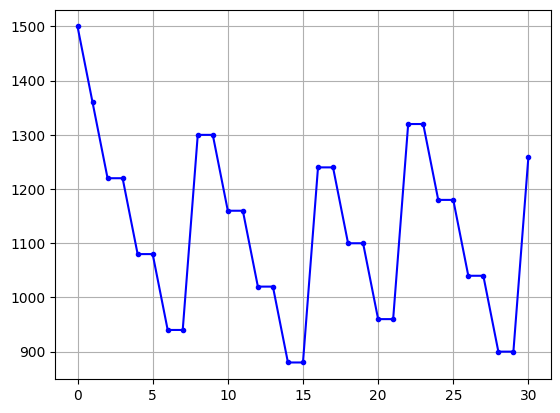

In [4]:
simtime = 31
env = simpy.Environment()
raw_mat = scm.RawMaterial(ID="RM1", name="raw materials mouse", extraction_quantity=650, 
                          extraction_time=1, mining_cost=0.01, cost=0.1) 

supplier = scm.Supplier(env=env, ID='S1', name='Supplier', node_type="infinite_supplier")

mouse = scm.Product(ID="B1", name="WM 1", manufacturing_cost=10, manufacturing_time=0, sell_price=300, buy_price=150,
                             raw_materials=[{"raw_material": raw_mat, "quantity": 1}], batch_size=2500)

distributor1 = scm.InventoryNode(env=env, ID='D1', name='Distribution Center 1', node_type="distributor",
                                capacity=1000, initial_level=1000, inventory_holding_cost=0.22,
                                replenishment_policy = scm.SSReplenishment, policy_param={'s':500, 'S':1000},
                                product_buy_price=150, product_sell_price=300)
distributor2 = scm.InventoryNode(env=env, ID='D2', name='Distribution Center 2', node_type="distributor",
                                capacity=1500, initial_level=1500, inventory_holding_cost=0.22,
                                replenishment_policy = scm.RQReplenishment, policy_param={'R':1000, 'Q':500},
                                product_buy_price=150, product_sell_price=300)

link1 = scm.Link(env=env, ID='L1', source=supplier, sink=distributor1, cost=10, lead_time=lambda: 1)
link2 = scm.Link(env=env, ID='L2', source=supplier, sink=distributor2, cost=10, lead_time=lambda: 1)

demand1 = scm.Demand(env=env, ID='demand_D1', name='Demand 1', order_arrival_model=lambda: 1, order_quantity_model=lambda:20, 
                     delivery_cost=lambda:10, lead_time=lambda: 1, demand_node=distributor1)
demand2 = scm.Demand(env=env, ID='demand_D2', name='Demand 2', order_arrival_model=lambda: 1, order_quantity_model=lambda:40, 
                     delivery_cost=lambda:10, lead_time=lambda: 1, demand_node=distributor1)
demand3 = scm.Demand(env=env, ID='demand_D3', name='Demand 3', order_arrival_model=lambda: 2, order_quantity_model=lambda:60, 
                     delivery_cost=lambda:10, lead_time=lambda: 1, demand_node=distributor2)
demand4 = scm.Demand(env=env, ID='demand_D4', name='Demand 4', order_arrival_model=lambda: 2, order_quantity_model=lambda:80, 
                     delivery_cost=lambda:10, lead_time=lambda: 1, demand_node=distributor2)

inventory_nodes = [supplier,distributor1, distributor2]
inventory_links = [link1, link2]
demand_nodes = [demand1, demand2, demand3, demand4]
scm.global_logger.enable_logging()
env.run(until=simtime)

import numpy as np
import matplotlib.pyplot as plt
supplynet = scm.create_sc_net(env=env, nodes = inventory_nodes, links = inventory_links, demands = demand_nodes)
supplynet = scm.simulate_sc_net(supplynet, sim_time=simtime)
for node in [supplier, distributor1, distributor2]:
    inv_levels = np.array(node.inventory.instantaneous_levels)
plt.plot(inv_levels[:,0], inv_levels[:,1], label='Inventory Level at D1', marker='.', color='blue')
plt.grid()

print_performance_metrics(supplynet)

In [ ]:
simtime = 31
env = simpy.Environment()
raw_mat = scm.RawMaterial(ID="RM1", name="raw materials mouse", extraction_quantity=650, 
                          extraction_time=1, mining_cost=0.01, cost=0.1) 

supplier = scm.Supplier(env=env, ID='S1', name='Supplier', node_type="infinite_supplier")

mouse = scm.Product(ID="B1", name="WM 1", manufacturing_cost=10, manufacturing_time=0, sell_price=300, buy_price=150,
                             raw_materials=[{"raw_material": raw_mat, "quantity": 1}], units_per_cycle=2500)

distributor1 = scm.InventoryNode(env=env, ID='D1', name='Distribution Center 1', node_type="distributor",
                                capacity=1000, initial_level=1000, inventory_holding_cost=0.22,
                                replenishment_policy = scm.SSWithSafetyReplenishment, policy_param={'s':500, 'S':1000, 'safety_stock':400},
                                product_buy_price=150, product_sell_price=300)
distributor2 = scm.InventoryNode(env=env, ID='D2', name='Distribution Center 2', node_type="distributor",
                                capacity=1500, initial_level=1500, inventory_holding_cost=0.22,
                                replenishment_policy = scm.RQReplenishment, policy_param={'R':1000, 'Q':500},
                                product_buy_price=150, product_sell_price=300)

link1 = scm.Link(env=env, ID='L1', source=supplier, sink=distributor1, cost=10, lead_time=lambda: 1)
link2 = scm.Link(env=env, ID='L2', source=supplier, sink=distributor2, cost=10, lead_time=lambda: 1)

demand1 = scm.Demand(env=env, ID='demand_D1', name='Demand 1', order_arrival_model=lambda: 1, order_quantity_model=lambda:20, 
                     delivery_cost=lambda:10, lead_time=lambda: 1, demand_node=distributor1)
demand2 = scm.Demand(env=env, ID='demand_D2', name='Demand 2', order_arrival_model=lambda: 1, order_quantity_model=lambda:40, 
                     delivery_cost=lambda:10, lead_time=lambda: 1, demand_node=distributor1)
demand3 = scm.Demand(env=env, ID='demand_D3', name='Demand 3', order_arrival_model=lambda: 2, order_quantity_model=lambda:60, 
                     delivery_cost=lambda:10, lead_time=lambda: 1, demand_node=distributor2)
demand4 = scm.Demand(env=env, ID='demand_D4', name='Demand 4', order_arrival_model=lambda: 2, order_quantity_model=lambda:80, 
                     delivery_cost=lambda:10, lead_time=lambda: 1, demand_node=distributor2)

inventory_nodes = [supplier,distributor1, distributor2]
inventory_links = [link1, link2]
demand_nodes = [demand1, demand2, demand3, demand4]
scm.global_logger.enable_logging()
env.run(until=simtime)

import numpy as np
import matplotlib.pyplot as plt
supplynet = scm.create_sc_net(nodes = inventory_nodes, links = inventory_links, demands = demand_nodes)
supplynet = scm.simulate_sc_net(supplynet, sim_time=simtime)
for node in [supplier, distributor1, distributor2]:
    inv_levels = np.array(node.inventory.instantaneous_levels)
plt.plot(inv_levels[:,0], inv_levels[:,1], label='Inventory Level at D1', marker='.', color='blue')
plt.grid()
print_performance_metrics(supplynet)



AttributeError: module 'utilities' has no attribute 'SSWithSafetyReplenishment'